## Comparing the implementations in SNNTorch and SpyTorch

In [1]:
from pathlib import Path

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

Matplotlib created a temporary cache directory at /tmp/matplotlib-aeb4is2b because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Data

In [2]:
batch_size = 128
num_hidden = 28*28
data_path = Path.home()/'RANCZLAB-NAS/iakov/data/torch_mnist'

dtype = torch.float
device = torch.device('cuda')

In [3]:
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0), (1))
])

mnist_train = datasets.MNIST(data_path, train=True, download=False, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=False, transform=transform)

In [4]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

temp_data = data.reshape(128,1,28*28).repeat(1,100,1)
print(temp_data.shape)
temp_data.device

torch.Size([128, 100, 784])


device(type='cuda', index=0)

In [6]:
weights_matrix = torch.rand((28*28, 28*28)).to(device) * 0.001

### SpyTorch

In [7]:
from model_spytorch import SNNModel
model = SNNModel(batch_size = 128, hidden_units = 28*28, num_timesteps = 100, step_length = 1/100, device = torch.device('cuda'), dtype = torch.float)
model.init_parameters()
model.alpha = float(np.exp(-(1/100)/5e-3))
model.beta = float(np.exp(-(1/100)/10e-3))
model.v1 = weights_matrix

mem_rec1, spk_rec1 = model.run_snn(temp_data)

### SNNTorch

In [8]:
class SNNTorchNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.fc1 = nn.Linear(28*28, 28*28)
        self.fc1 = nn.Identity()
        # lif1 = snn.Leaky(beta=0.95)
        self.lif1 = snn.RSynaptic(alpha=float(np.exp(-(1/100)/5e-3)), beta=float(np.exp(-(1/100)/10e-3)), linear_features=num_hidden)
        self.lif1.recurrent.weight.data = weights_matrix
        self.lif1.recurrent.bias.data = torch.zeros_like(self.lif1.recurrent.bias.data)
        # self.fc1.weight.data = torch.ones_like(self.fc1.weight.data)
        # self.fc1.bias.data = torch.zeros_like(self.fc1.bias.data)

    def forward(self, x):
        # mem1 = lif1.init_leaky()
        spk1, syn1, mem1 = self.lif1.init_rsynaptic()
        # spk1, syn1, mem1 = spk1.cuda(), syn1.cuda(), mem1.cuda()

        spk1_rec = []
        mem1_rec = []
        syn1_rec = []

        # fc1.weight.data = net.fc1.weight.data.detach().to(device)
        # fc1.bias.data = fc1.bias.data.to(device)
        for step in range(100):
            cur1 = self.fc1(x[:,step,:])
            # spk1, mem1 = lif1(cur1, mem1)
            spk1, syn1, mem1 = self.lif1(cur1, spk1, syn1, mem1)
            # spk1, syn1, mem1 = self.lif1(x[:,step,:], spk1, syn1, mem1)
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            syn1_rec.append(syn1)
        # spk1_rec, mem1_rec= torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0)
        spk1_rec = torch.stack(spk1_rec)
        mem1_rec = torch.stack(mem1_rec)
        syn1_rec = torch.stack(syn1_rec)
        
        return spk1_rec, mem1_rec, syn1_rec

snntorchnet = SNNTorchNet().cuda()
spk1_rec, mem1_rec, syn1_rec = snntorchnet(temp_data)

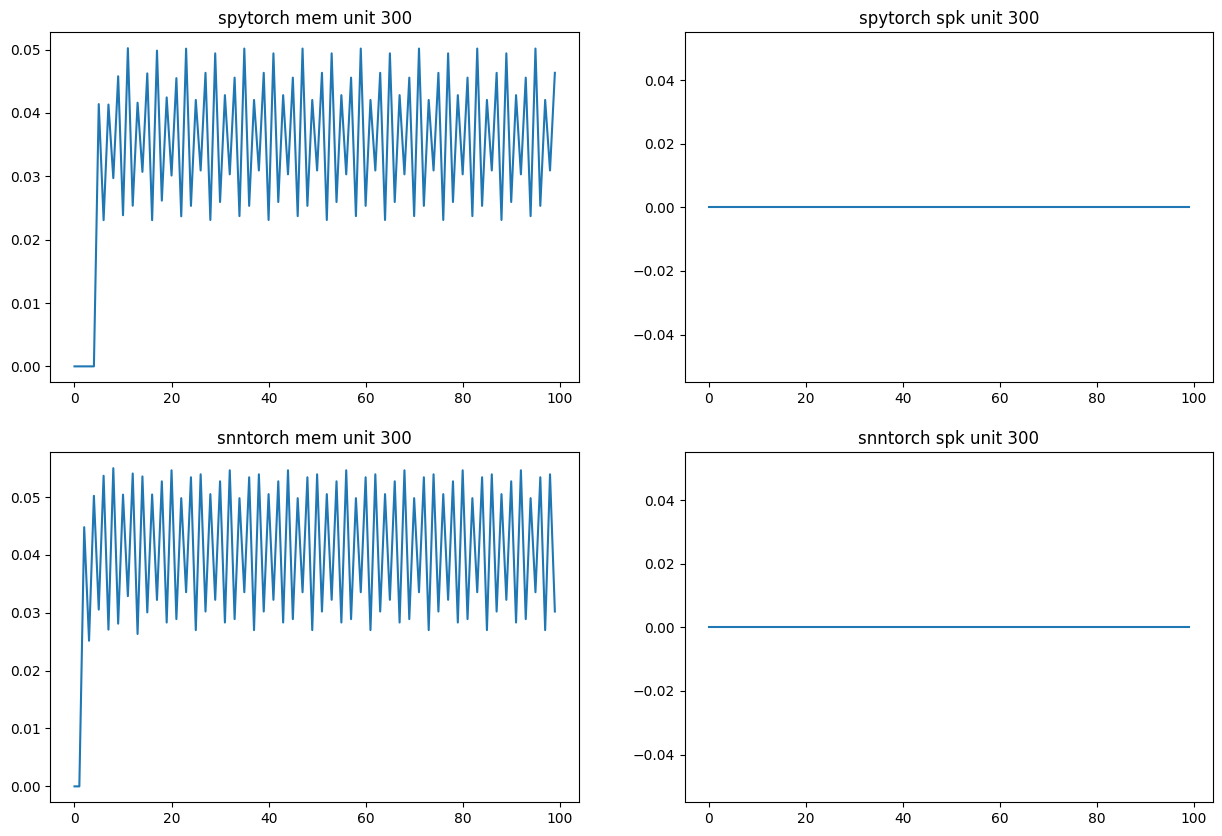

In [9]:
UNIT_ID = 300
BATCH_ID = 0
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(15,10))
ax[0][0].set_title(f'spytorch mem unit {UNIT_ID}')
ax[0][0].plot(mem_rec1.cpu().numpy()[BATCH_ID,:,UNIT_ID])
ax[0][1].set_title(f'spytorch spk unit {UNIT_ID}')
ax[0][1].plot(spk_rec1.cpu().numpy()[BATCH_ID,:,UNIT_ID])
ax[1][0].set_title(f'snntorch mem unit {UNIT_ID}')
ax[1][0].plot(mem1_rec.detach().cpu().numpy()[:,BATCH_ID,UNIT_ID])
ax[1][1].set_title(f'snntorch spk unit {UNIT_ID}')
ax[1][1].plot(spk1_rec.detach().cpu().numpy()[:,BATCH_ID,UNIT_ID])
plt.show()

### Comparing single layer

In [10]:
class SurrGradSpike(torch.autograd.Function):
    
    # The same ATan surrogate gradient as used by default in SNNTorch
    @staticmethod
    def forward(ctx, input, alpha=2.0):
        ctx.save_for_backward(input)
        ctx.alpha = alpha
        out = (input > 0).float()
        return out
    @staticmethod
    def backward(ctx, grad_output):
        (input,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = (ctx.alpha / 2 / (1 + (torch.pi / 2 * ctx.alpha * input).pow_(2)) * grad_input)
        return grad    


# snntorch
test_lif = snn.RSynaptic(alpha=float(np.exp(-(1/100)/5e-3)), beta=float(np.exp(-(1/100)/10e-3)), linear_features=28*28)
test_lif.recurrent.weight.data = weights_matrix.cpu()
test_lif.recurrent.bias.data = torch.zeros_like(test_lif.recurrent.bias.data).cpu()
    
test_spk_snn, test_syn_snn, test_mem_snn = test_lif.init_rsynaptic()
test_mem_rec_snn = []

# spytorch
spike_fn = SurrGradSpike.apply
alpha = float(np.exp(-(1/100)/5e-3))
beta = float(np.exp(-(1/100)/10e-3))
v1 = weights_matrix

test_syn_spy = torch.zeros((1,28*28)).cpu()
test_mem_spy = torch.zeros((1,28*28)).cpu()
test_mem_rec_spy = []
    
for step in range(100):
    test_spk_snn, test_syn_snn, test_mem_snn = test_lif(temp_data[:1,step,:].cpu(), test_spk_snn.cpu(), test_syn_snn.cpu(), test_mem_snn.cpu())
    test_mem_rec_snn.append(test_mem_snn.detach())
    
    
    thresholded_mem = test_mem_spy - 1
    out = spike_fn(thresholded_mem).cpu() # surrogate heaviside

    new_syn = alpha * test_syn_spy + temp_data[:1,step,:].cpu() + torch.einsum("ab,bc->ac", (out, v1.cpu())) # input are unweighted
    new_mem = (beta * test_mem_spy + test_syn_spy) * (1 - out.detach()) # .detach() because we don't want to backprop through the reset

    test_mem_rec_spy.append(new_mem)
    # spk_rec.append(out)

    test_mem_spy = new_mem
    test_syn_spy = new_syn

test_mem_rec_snn = torch.stack(test_mem_rec_snn)
test_mem_rec_spy = torch.stack(test_mem_rec_spy)

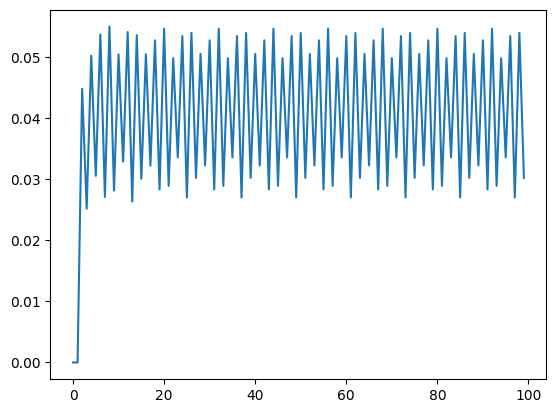

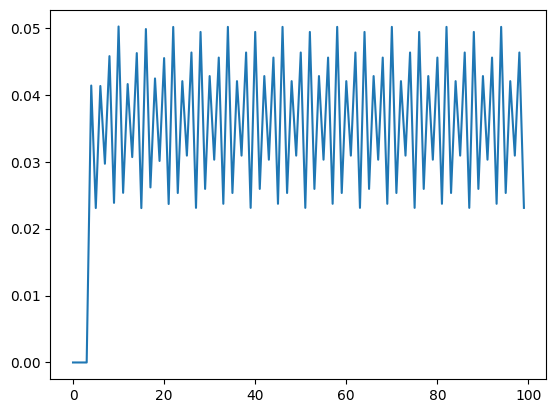

In [11]:
plt.plot(test_mem_rec_snn.detach().cpu().numpy()[:,0,300])
plt.show()
plt.plot(test_mem_rec_spy.detach().cpu().numpy()[:,0,300])
plt.show()